In [1]:
# Cell 1

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
def upload_and_process_files():
    uploaded = files.upload()
    data_frames = []
    scalers = []

    num_files = len(uploaded)
    fig, axs = plt.subplots(1, num_files, figsize=(8*num_files, 6), constrained_layout=True)  # Adjust figsize for desired width and height
    if num_files == 1:
        axs = [axs]

    for i, (filename, content) in enumerate(uploaded.items()):
        if filename.endswith('.svc'):
            df = pd.read_csv(
                io.StringIO(content.decode('utf-8')),
                skiprows=1,
                header=None,
                delim_whitespace=True
            )
            df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
            df = df.iloc[:, [0, 1, 3]]  # Select x, y, and pen_status
            data_frames.append(df)
            scaler = MinMaxScaler()
            normalized_data = scaler.fit_transform(df[['x', 'y']])
            scalers.append(scaler)

            # Plot original data with rotated orientation
            on_paper = df[df['pen_status'] == 1]
            in_air = df[df['pen_status'] == 0]
            axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
            axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
            axs[i].set_title(f'Original Data {i + 1}')
            axs[i].set_xlabel('-y')  # Adjusted labels to reflect the rotated orientation
            axs[i].set_ylabel('x')   # Adjusted labels to reflect the rotated orientation
            axs[i].legend()

            # Set fixed aspect ratio
            axs[i].set_aspect('equal')

    plt.show()

    combined_data = np.vstack([scaler.transform(df[['x', 'y']]) for df, scaler in zip(data_frames, scalers)])

    return data_frames, combined_data, scalers

data_frames, combined_data, scalers = upload_and_process_files()
print(f"Processed data shape: {combined_data.shape}")


In [ ]:
# Cell 3
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error

class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(2,)),  # Changed input shape to 2
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(2)  # Changed output shape to 2
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        return self.decoder(z)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

# Function to compute loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(x, x_reconstructed))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss, kl_loss, model.beta * kl_loss

# Initialize the model and optimizer
latent_dim = 16
beta = 0.00015188813368
learning_rate = 0.0067158732266193

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
#Cell 4
# Define the train_step function using @tf.function to avoid retracing
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        total_loss = reconstruction_loss + total_kl_loss
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, reconstruction_loss, kl_loss

#Train the model
batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices(combined_data).shuffle(10000).batch(batch_size)

epochs = 1000
early_stopping_patience = 100
min_delta = 0.0001
best_loss = float('inf')
patience_counter = 0

total_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
mae_history = []
mse_history = []
nrmse_history = []

for epoch in range(epochs):
    total_loss = 0
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = len(train_dataset)

    # Use tqdm for the progress bar
    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for batch in train_dataset:
            total_loss_batch, reconstruction_loss, kl_loss = train_step(vae, batch, optimizer)
            total_loss += total_loss_batch
            reconstruction_loss_sum += reconstruction_loss
            kl_loss_sum += kl_loss
            pbar.update(1)
            pbar.set_postfix({'loss': float(total_loss_batch)})

    avg_total_loss = total_loss / num_batches
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    total_loss_history.append(avg_total_loss)
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)

    # Calculate MAE, MSE, NRMSE
    augmented_data = vae.decode(tf.random.normal(shape=(combined_data.shape[0], latent_dim))).numpy()
    mae = mean_absolute_error(combined_data[:, :2], augmented_data)
    mse = mean_squared_error(combined_data[:, :2], augmented_data)
    rmse = np.sqrt(mse)
    nrmse = rmse / (combined_data[:, :2].max() - combined_data[:, :2].min())

    mae_history.append(mae)
    mse_history.append(mse)
    nrmse_history.append(nrmse)


    # Early Stopping
    if avg_total_loss < best_loss - min_delta:
        best_loss = avg_total_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

print("Training completed.")
plt.ioff()  # Turn off interactive mode
plt.show()

# Plot loss history
plt.figure(figsize=(10, 5))
plt.plot(total_loss_history, label='Total Loss')
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot MAE, MSE, and NRMSE history
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(mae_history, label='MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(mse_history, label='MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Mean Squared Error Over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 5/1000:  26%|██▌       | 100/382 [00:00<00:02, 106.25batch/s, loss=0.000431]

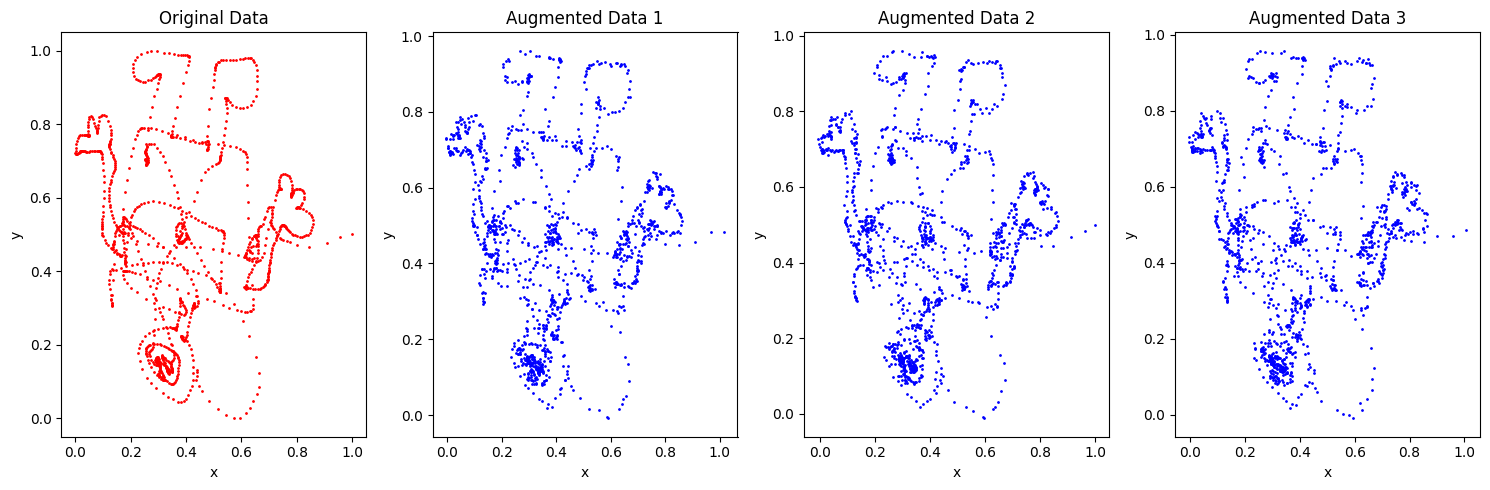

In [ ]:
# Cell 5
def generate_augmented_data(model, num_augmented_files, num_augmented_samples_per_file):
    augmented_datasets = []
    for _ in range(num_augmented_files):
        mean, logvar = model.encode(tf.convert_to_tensor(combined_data[:, :2], dtype=tf.float32))  # Changed input shape to 2
        z = model.reparameterize(mean, logvar)
        augmented_data = model.decode(z).numpy()
        augmented_datasets.append(augmented_data[:num_augmented_samples_per_file])
    return augmented_datasets

num_augmented_files = 3  # You can change this number
num_augmented_samples_per_file = combined_data.shape[0] // len(data_frames)  # Assuming same number of samples per file

augmented_datasets = generate_augmented_data(vae, num_augmented_files, num_augmented_samples_per_file)

# Visualize the original and augmented data side by side
fig, axs = plt.subplots(1, num_augmented_files + 1, figsize=(15, 5))
axs[0].scatter(combined_data[:, 0], combined_data[:, 1], c='r', s=1)
axs[0].set_title('Original Data')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

for i, augmented_data in enumerate(augmented_datasets):
    axs[i+1].scatter(augmented_data[:, 0], augmented_data[:, 1], c='b', s=1)
    axs[i+1].set_title(f'Augmented Data {i+1}')
    axs[i+1].set_xlabel('x')
    axs[i+1].set_ylabel('y')

plt.tight_layout()
plt.show()

In [ ]:
# Function to prepare data for predictive score
def prepare_predictive_data(combined_data, augmented_datasets):
    X_real = combined_data[:, :-1]  # All except last time step
    y_real = combined_data[:, -1]   # Last time step

    X_synthetic = np.vstack([data[:, :-1] for data in augmented_datasets])  # All except last time step
    y_synthetic = np.hstack([data[:, -1] for data in augmented_datasets])   # Last time step

    return X_real, y_real, X_synthetic, y_synthetic

# Calculate Post-Hoc Predictive Score with MAPE
def post_hoc_predictive_score(combined_data, augmented_datasets):
    X_real, y_real, X_synthetic, y_synthetic = prepare_predictive_data(combined_data, augmented_datasets)
    scaler = MinMaxScaler()
    X_real_scaled = scaler.fit_transform(X_real)
    X_synthetic_scaled = scaler.transform(X_synthetic)

    mapes = []

    for _ in range(10):
        model = Sequential()
        model.add(Dense(50, input_dim=X_synthetic_scaled.shape[1], activation='relu'))
        model.add(Dense(1))

        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(X_synthetic_scaled, y_synthetic, epochs=10, batch_size=32, verbose=0)

        y_pred = model.predict(X_real_scaled)
        mape = mean_absolute_percentage_error(y_real, y_pred)
        mapes.append(mape)

    mean_mape = np.mean(mapes)
    std_mape = np.std(mapes)
    return mean_mape, std_mape

# Example usage (assuming combined_data and augmented_datasets are defined)
mean_mape, std_mape = post_hoc_predictive_score(combined_data, augmented_datasets)
print(f"Mean MAPE: {mean_mape}, Std MAPE: {std_mape}")

In [ ]:
# Function to prepare data for LSTM
def prepare_lstm_data(combined_data, augmented_datasets):
    print(f"Combined Data Shape: {combined_data.shape}")
    print(f"Augmented Datasets Length: {len(augmented_datasets)}")

    # Stack combined_data and augmented_datasets
    X = np.vstack([combined_data] + augmented_datasets)

    # Create labels: 0 for combined_data, 1 for each augmented dataset
    y = np.hstack([np.zeros(len(combined_data))] + [np.ones(data.shape[0]) for data in augmented_datasets])

    return X, y

# Calculate Post-Hoc Discriminative Score with LSTM
def post_hoc_discriminative_score(combined_data, augmented_datasets):
    X, y = prepare_lstm_data(combined_data, augmented_datasets)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Reshape X_train and X_test for LSTM input
        X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # (samples, time steps, features)
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])      # (samples, time steps, features)

        model = Sequential()
        model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=0)
        y_pred = model.predict(X_test)
        y_pred_classes = np.where(y_pred > 0.5, 1, 0)  # Threshold predictions at 0.5 for binary classification

        accuracy = accuracy_score(y_test, y_pred_classes)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    return mean_accuracy, std_accuracy

# Example usage
mean_acc, std_acc = post_hoc_discriminative_score(combined_data, augmented_datasets)
print(f"Mean Accuracy: {mean_acc}, Std Accuracy: {std_acc}")

Combined Data Shape: (21262, 2)
Augmented Datasets Length: 3
133/133 [==============================] - 1s 2ms/step
Mean Accuracy: 0.5320179060146576, Std Accuracy: 0.010189873897354098


In [ ]:
# Cell 6
def download_augmented_data(augmented_datasets, scalers):
    for i, augmented_data in enumerate(augmented_datasets):
        scaler = scalers[0]  # Assuming the same scaler is used for all since normalization is similar
        augmented_data_original_scale = scaler.inverse_transform(augmented_data)

        df_augmented = pd.DataFrame(augmented_data_original_scale, columns=['x', 'y'])
        output_filename = f"augmented_{i+1}.svc"
        df_augmented.to_csv(output_filename, index=False, sep=' ', header=False)
        files.download(output_filename)

download_augmented_data(augmented_datasets, scalers)